## Spatial Nets

In [31]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [32]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

In [33]:
# Navigate to the relevant directory
os.chdir('/Users/Yuval/Desktop/Pawsey/data/')

In [94]:
df = pd.read_json('cleaned_events/cleaned_events_Spain.json')
df = df.loc[df['matchId'] == 2565711]

In [95]:
def event_handling(df):
    # Cleans things up based on our interpretation of the events and how they relate to passes. Note the meaning of
    # the events:
    # 1 - duels (this is a hard one to define as it means many different things)
    # 2 - fouls
    # 3 - free kicks / corners (hence we add a node so that it picks these up as the first play in the chain)
    # 4 - keeper leaving their line
    # 7 - Touch, acceletation or clearance
    # 8 - Pass - simple/smart, cross (main data we're after for this)
    # 9 - Reflexes / save (however if tagged as inaccurate it means there was a goal)
    # 10- Shot (add a shot node)
    
    df = df.loc[ df['eventId'] != 9]
    df = df.loc[ df['eventId'] != 2]
    df = df.loc[ df['eventId'] != 4]
    df = df.loc[ (df['eventId'] != 1) | (df['Result'] == 'Accurate')]
    df = df.loc[ df['eventId'] != 7]
    
    #Check this later
    df = df.loc[df['attackMetres'] >= -30]

    # Create some new columns to see where passes ended up etc
    #df["next_event"] = df['eventId'].shift(-1)
    #df["next_teamId"] = df["teamId"].shift(-1)
    #df["next_player"] = df["shortName"].shift(-1)
    #df.loc[ df["next_event"] == 3, 'next_player'] = 0.5
    #df.loc[ df["eventId"] == 10, 'next_player'] = 0
    
    return df

In [96]:
df = event_handling(df)

In [97]:
df.head()

,eventId,subEventName,playerId,matchId,teamId,matchPeriod,eventSec,subEventId,id,Result,subEventDescription,xStart,xEnd,yStart,yEnd,attackMetres
267225,8,Simple pass,7972,2565711,676,1H,5.040873,85,216986174,Accurate,generic play,49,38,50,43,-11
267226,8,Simple pass,3346,2565711,676,1H,6.817835,85,216986175,Accurate,generic play,38,28,43,65,-10
267227,8,Simple pass,3341,2565711,676,1H,9.226385,85,216986176,Accurate,generic play,28,27,65,39,-1
267228,8,Simple pass,7860,2565711,676,1H,11.371455,85,216986177,Accurate,generic play,27,25,39,13,-2
267229,8,Simple pass,3269,2565711,676,1H,12.875549,85,216986178,Accurate,generic play,25,37,13,37,12


In [98]:
#Define the zones

def zones(event_df, start_or_end):

    conditions = [
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 36))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 36)& (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 64)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 16.5)& (event_df['x'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 16.5) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <=  25))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 16.5) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 16.5) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 33)& (event_df['x'+ start_or_end] >= 16.5) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] >= 0))& (event_df['y'+ start_or_end] <=  25)),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <=  75))),
            (((event_df['x'+ start_or_end] <= 50)& (event_df['x'+ start_or_end] > 33) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <=  100))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <=  50))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 67)& (event_df['x'+ start_or_end] > 50) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] >= 0)& (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 25)& (event_df['y'+ start_or_end] <= 50))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 50)& (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] < 83.5)& (event_df['x'+ start_or_end] > 67) & (event_df['y'+ start_or_end] > 75)& (event_df['y'+ start_or_end] <= 100))),
        
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] >= 0) & (event_df['y'+ start_or_end] <= 25))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 25) & (event_df['y'+ start_or_end] <=  36))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 36) & (event_df['y'+ start_or_end] <= 64))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 64) & (event_df['y'+ start_or_end] <= 75))),
            (((event_df['x'+ start_or_end] <= 100) & (event_df['x'+ start_or_end] > 83.5) & (event_df['y'+ start_or_end] > 75) & (event_df['y'+ start_or_end] <= 100)))
            ]

    # create a list of the values we want to assign for each condition
    values = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

    # create a new column and us np.select to assign values to it using our lists as arguments
    event_df['Zone'+ start_or_end] = np.select(conditions, values)
    
    return event_df


In [99]:
def transitions(df, teamIds):
    
    # Create a Transitions column which has the start and end zones
    df['Transition'] = list(zip(df['ZoneStart'], df['ZoneEnd']))
    
    # Get a transition list for each team
    trans = []
    for team in teamIds:    
        temp = df.loc[df['teamId'] == team]
        trans.append(list(temp['Transition']))

    return trans[0], trans[1]

In [101]:
def weighted_passes(passes):
    # Builds a network for the team based on the passes as edges
    n = nx.DiGraph()
    for (i,j) in passes:
        if n.has_edge(i,j):
            n[i][j]['weight'] += 1
        else:
            n.add_edge(i,j, weight = 1)
    
    # Remove node 0.5 as only used to signify start of plays from free kicks / corners
    if 0.5 in n.nodes():
        n.remove_node(0.5)
        
    return n

In [102]:
def continuous_time(df):
    # Converts to a continuous 90 min (ie 90*60 = 5400 second) game
    firsthalf = df.loc[df['matchPeriod'] == '1H']
    first_half_length = list(firsthalf['eventSec'])[-1]
    df.loc[ df.matchPeriod == '2H' , 'eventSec'] += first_half_length
    return df

In [103]:
def sliding_window(df, teams):
    # This function iterates sliding 10 minute windows, moving forward by 30 seconds each time and calculate a 
    # team's entropy during that 30 second window

    metrics1 = []
    metrics2 = []
    
    # Iterate sliding windows over the game length
    for i in range(0,int(list(df['eventSec'])[-1])-600,30):
        
        # locate the window in the database
        temp_df = df.loc[df['eventSec'] < i + 600]
        temp_df = temp_df.loc[temp_df['eventSec'] > i]
        
        # Get pass list, create a network, and find that network's entropy
        trans1, trans2 = transitions(temp_df,teams)

        net1 = weighted_passes(trans1)
        net2 = weighted_passes(trans2)

        # The team's total amount of passes during that 10 minute window 
        tot1 = 0
        tot2 = 0
        for item in list(net1.edges(data=True)):
            tot1 += item[2]['weight']
        for item in list(net2.edges(data=True)):
            tot2 += item[2]['weight']
        
        
        if tot1 > 0:
            met1 = find_entropy(net1)
        else:
            met1 = 0
        if tot2 > 0:
            met2 = find_entropy(net2)
        else:
            met2 = 0
            
        metrics1.append(met1)
        metrics2.append(met2)
    
    return metrics1[:160], metrics2[:160]

In [104]:
df = continuous_time(df)

df = zones(df, "Start")
df = zones(df, "End")

teams = list(set(df['teamId']))

#trans1, trans2 = transitions(df,teams)
met1, met2 = sliding_window(df,[675,676])

In [116]:
minutes = [i/2 for i in range(10,170)]

In [117]:
len(met1)

160

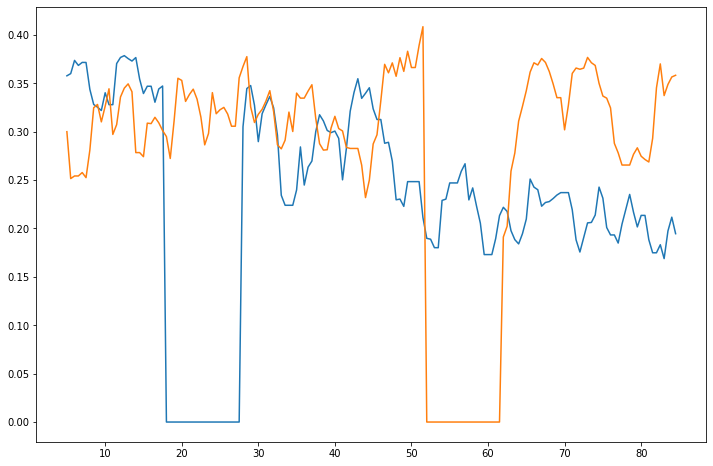

In [119]:
plt.figure(figsize = (12,8))
plt.plot(minutes,met1)
plt.plot(minutes,met2)

In [120]:
temp_df = df.loc[df['eventSec'] < 3600]
temp_df = temp_df.loc[temp_df['eventSec'] > 3000]

trans1, trans2 = transitions(temp_df,teams)

In [121]:
net1 = weighted_passes(trans1)
net2 = weighted_passes(trans2)

In [43]:
pos = {1: (8.25, 12.5), 2: (8.25, 30.5), 3: (8.25, 50), 4: (8.25, 69.5), 5: (8.25, 87.5), 6:(24.75, 12.5), 
       7: (24.75, 37.5), 8: (24.75, 62.5), 9: (24.75, 87.5), 10: (41.5,12.5), 11: (41.5, 37.5), 12: (41.5, 62.5),
      13: (41.5, 87.5), 14: (58.5, 12.5), 15:(58.5, 37.5), 16: (58.5, 62.5), 17: (58.5, 87.5), 18: (75.25, 12.5),
      19:(75.25,37.5), 20: (75.25, 62.5), 21: (75.25, 87.5), 22: (91.75, 12.5), 23:(91.75,30.5), 24:(91.75, 50), 
       25:(91.75, 69.5), 26: (91.75, 87.5)} 

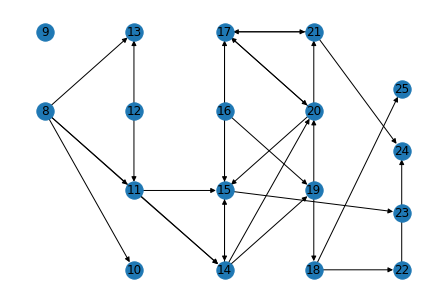

In [122]:
nx.draw(net1, with_labels = True, pos = pos, c = 'g')
#sorted(dict(net1.degree()).items(), key=lambda x: x[1], reverse=True)

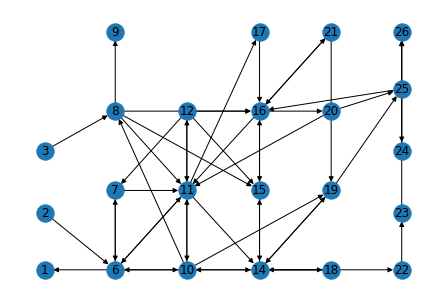

In [123]:
nx.draw(net2, with_labels = True, pos = pos)

In [126]:
find_entropy(net2)

0.0

How is the above network only have an entropy of 0??????

In [46]:
sorted(dict(net2.degree()).items(), key=lambda x: x[1], reverse=True)

[(11, 25),
 (8, 25),
 (12, 25),
 (15, 25),
 (10, 23),
 (16, 23),
 (7, 21),
 (3, 21),
 (19, 21),
 (17, 20),
 (6, 19),
 (20, 19),
 (14, 18),
 (13, 18),
 (21, 17),
 (9, 14),
 (18, 14),
 (26, 13),
 (22, 12),
 (24, 10),
 (1, 9),
 (5, 8),
 (23, 8),
 (25, 8),
 (2, 7),
 (4, 5)]

In [61]:
for (i,j) in list(net1.edges()):
    if i == j:
        print(i,j)

13 13
21 21
16 16
6 6
18 18
19 19
26 26
24 24
7 7
10 10
11 11
8 8
17 17
12 12
14 14
22 22
23 23
15 15
5 5
9 9
1 1
3 3


In [47]:
# Defines a function to calculate the entropy of each node from the transition matrix.
def entropy(row):
    enode = 0
    for item in row:
        if item > 0:
            enode -= item * math.log10(item) # Entropy formula for each node.
    return enode

In [48]:
def find_entropy(net):
    # This function attempts to calculate a team's entropy- i.e. their unpredictability.
    
    n = net
    n = nx.relabel_nodes(n, {0:'ZZ'})
    
    # A stochastic graph gives the probabilities of connections between certain platers       
    prob = nx.stochastic_graph(n)
    
    # Allows us to sort nodes alphabetically so that we can easily remove shot node later
    playerlist = sorted(list(n.nodes()))
    
    # Generates transition matrix
    probmat = nx.adjacency_matrix(prob, nodelist = playerlist)
    probmat = probmat.todense()
    matrix = np.array(probmat) # turns it into numpy array so that we can operate on it

    entnode =  np.apply_along_axis( entropy, axis=1, arr = matrix ) # calculates entropy for each node

    entnode = entnode[:-1] # Gets rid of entropy of shot node

    entrop = sum(entnode)/len(n.nodes()) # Gets the average
        
    return entrop

In [49]:
find_entropy(net1)

0.6967504988148941

In [50]:
find_entropy(net2)

0.7359860678764409

In [ ]:
# For some reason nx.draw() doesn't draw the self loops... don't know why :(

In [ ]:
## Test some exception related tings

In [53]:
temp = df.loc[df['ZoneStart'] == 26]
temp.loc[temp['ZoneEnd']==1]

,eventId,subEventName,playerId,matchId,teamId,matchPeriod,eventSec,subEventId,id,Result,subEventDescription,xStart,xEnd,yStart,yEnd,attackMetres,ZoneStart,ZoneEnd,Transition
267253,8,Cross,4501,2565711,675,1H,71.685097,80,216986242,Inaccurate,right_foot blocked,84,0,86,0,-84,26,1,"(26, 1)"


In [16]:
zeros = df.loc[df['xEnd'] == 0]
zeros = zeros.loc[zeros['yEnd'] == 0]
zeros

In [66]:
init = pd.read_json('events/events_Spain.json')
init = init.loc[init['matchId'] == 2565711]

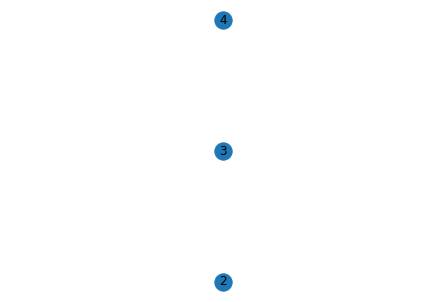

In [72]:
n = nx.Graph()
n.add_edges_from([(4,4),(3,3),(2,2)])
#(1,2),(2,3),(4,5),
nx.draw(n,with_labels = True, pos = pos)

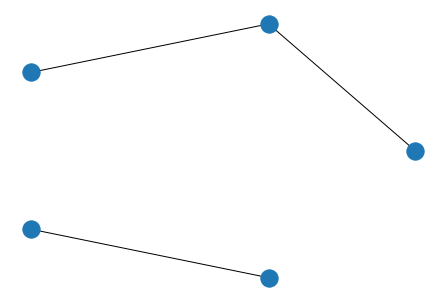

In [70]:
nx.draw_circular(n)